# Team Members
    - Mohamed Mahmoud Rezk   ID: 2002114
    - Marten Ehab Fouad      ID: 2101642

## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## metrics imports
import sklearn.metrics as metrics 

%matplotlib inline

random_state = 44 

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
data.columns

Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')

In [4]:
data.shape

(863, 15)

### Dropping the `Unnamed: 0` column 

In [5]:
data.drop(columns=["Unnamed: 0"], inplace=True)

### Looking at the description of the data

In [6]:
data.describe()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.00000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,76.645423,16.995365,0.849363,49.400000,0.181924,0.107764,12.13905,28.002317,18.298957,11.840093,2.993048,0.998841,0.995365,0.125145
std,39.200264,7.809951,0.726062,15.079203,0.386005,0.310261,3.99787,7.473231,2.864064,1.183771,0.127251,0.034040,2.358767,0.331075
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,11.000000,0.000000,40.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,87.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,110.000000,24.000000,1.000000,57.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.00000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


In [7]:
print("Unique Values for each column")
print("-----------------------------")
for col in data.columns:
    print(col, data[col].nunique())

Unique Values for each column
-----------------------------
location 139
country 34
gender 3
age 81
vis_wuhan 2
from_wuhan 2
symptom1 25
symptom2 32
symptom3 20
symptom4 13
symptom5 4
symptom6 2
diff_sym_hos 18
result 2


### Show correlation heatmap between training features

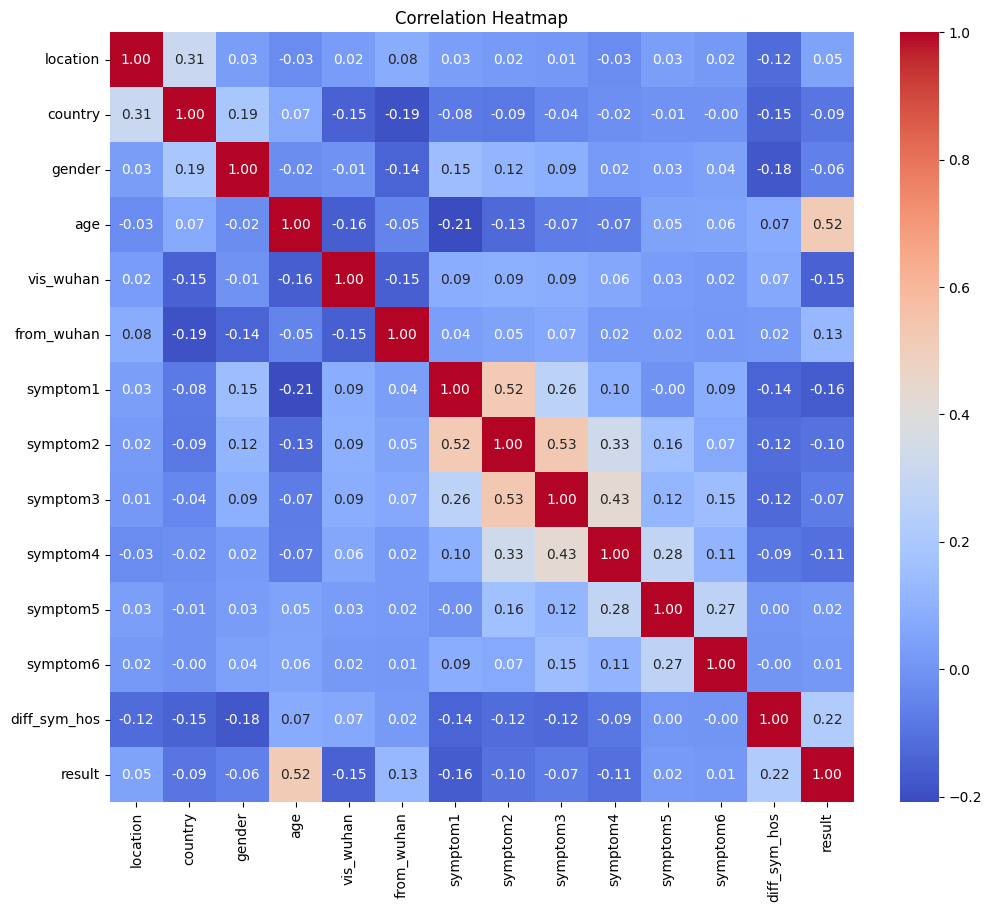

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Observations

### `result` is highly dependent on `age` and `diff_sym_hos` columns which appears in the correlation heatmap making them the principal components.

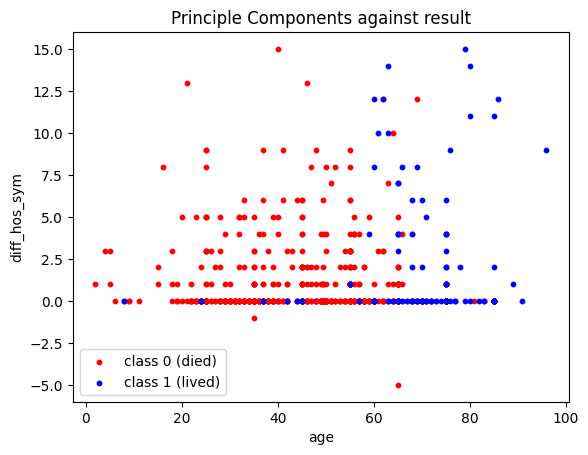

In [9]:
X_reduced = data[["age", "diff_sym_hos"]].to_numpy()
X_reduced_0  = X_reduced[data["result"] == 0]
X_reduced_1  = X_reduced[data["result"] == 1]
plt.title("Principle Components against result")
plt.scatter(X_reduced_0[:,0], X_reduced_0[:,1], s=10, color="red", label="class 0 (died)")
plt.scatter(X_reduced_1[:,0], X_reduced_1[:,1], s=10, color="blue", label="class 1 (lived)")
plt.xlabel("age")
plt.ylabel("diff_hos_sym")
plt.legend()
plt.show()

### From the plot above, it is obvious that there is not a nice boundary between the two classes

### PROBLEM 1: There is a third gender (value of `2`)  

In [10]:
data["gender"].value_counts()

gender
1    389
0    302
2    172
Name: count, dtype: int64

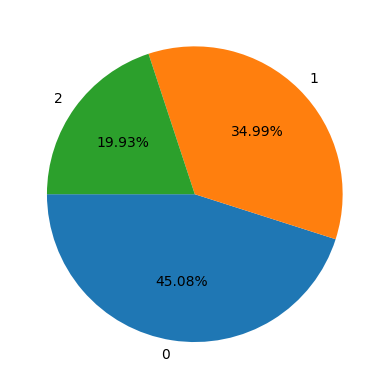

In [11]:
plt.pie(data["gender"].value_counts(), labels=[0,1,2], startangle=180, autopct="%2.2f%%")
plt.show()

#### FIX: Since the "third/undefined" gender takes around 20% of the data, the `gender` column can be omitted

In [12]:
data.drop(columns=["gender"], inplace=True)

### PROBLEM 2: the min value of `diff_sym_hos` column is negative

In [13]:
data[data["diff_sym_hos"] < 0]

,location,country,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
223,56,18,35.0,0,0,6,31,19,12,3,1,-1,0
240,128,18,65.0,0,0,6,31,19,12,3,1,-5,0


#### FIX: Dropping rows that have negative values in `diff_sym_hos` column

In [14]:
negative_diff_idxs = data[data["diff_sym_hos"] < 0].index.values.tolist()
data.drop(index=negative_diff_idxs, inplace=True)
data.shape

(861, 13)

### PROBLEM 3: `symptom5` and `symptom6` column experience no variation with almost zero correlation with `result` 

In [15]:
data["symptom5"].value_counts()

symptom5
3    858
2      1
1      1
0      1
Name: count, dtype: int64

In [16]:
data["symptom6"].value_counts()

symptom6
1    860
0      1
Name: count, dtype: int64

#### FIX: dropping the `symptom5` and `symptom6` columns

In [17]:
data.drop(columns=["symptom5", "symptom6"], inplace=True)
data.shape

(861, 11)

## Preparing features for training

In [18]:
X = (data.loc[:, data.columns != "result"]).to_numpy()
y = data["result"].to_numpy()
# Splitting data to train and test
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)

### Normalizing training data (0 mean and 1 std)

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train_)
X_test = sc.transform(X_test_)

## Preparing mertics functions

In [20]:
CLASSIFIERS_SCORES = {}
metrics_funcs = {
    "Accuracy": metrics.accuracy_score,
    "Precision": metrics.precision_score,
    "Recall": metrics.recall_score,
    "F1-score": metrics.f1_score,
    "ROC/AUC": metrics.roc_auc_score,
}

def compute_model_metrics(model, X_test, y_test):
    res = dict()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    for metric in metrics_funcs:
        if metric == "ROC/AUC":
            res[metric] = metrics_funcs[metric](y_test, y_pred_proba)
        else:
            res[metric] = metrics_funcs[metric](y_test, y_pred)
    return res, y_pred

def print_metrics(msg, metrics_):
    print(msg)
    print("-------------------------------")
    for metric in metrics_:
        print(f"{metric} = {metrics_[metric]:.3f}")

def display_confusion_matrix(y_true, y_pred):
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=[0,1])
    plt.show()

def display_roc_graph(model, X_test, y_test):
    dis = metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)
    dis.ax_.plot([0,1], [0,1], "r--")
    plt.grid()
    plt.show()

def plot_metrics_histograms(scores):
    metrics_vals = defaultdict(dict)
    colors = ["red", "green", "blue", "orange", "cyan"]
    for classifer in scores:
        for metric in scores[classifer]:
            metrics_vals[metric][classifer] = scores[classifer][metric]
            
    fig, axs = plt.subplots(len(metrics_vals), 1, tight_layout=True, figsize = (2 * len(scores), 5 * len(metrics_vals)))
    for i,metric in enumerate(metrics_vals):
        axs[i].set_title(metric)
        keys = metrics_vals[metric].keys()
        vals = metrics_vals[metric].values()
        axs[i].bar(keys, vals, color=colors[:len(scores)])
    plt.show()

# K-Nearest Neighbours Classifier

### Find the best K with grid search and cross validation. Usually, the best K is smaller than $\sqrt{N}$ where $N$ is number of training samples

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

maxk = np.ceil(np.sqrt(X_train.shape[0]) + 1)
knn = KNeighborsClassifier()
param_grid_knn = {
    "n_neighbors": np.arange(1, int(maxk)),
    "weights": ["distance", "uniform"],    
}
knn_cv = GridSearchCV(knn, param_grid_knn, cv=7, verbose=1, scoring="roc_auc")
knn_cv.fit(X_train, y_train)
best_params_knn = knn_cv.best_params_
print("Tuned knn parameters:", best_params_knn)

Fitting 7 folds for each of 54 candidates, totalling 378 fits
Tuned knn parameters: {'n_neighbors': 10, 'weights': 'distance'}


## Test tuned KNN model

In [22]:
knn_tuned = KNeighborsClassifier(**best_params_knn)
knn_tuned.fit(X_train, y_train)
knn_metrics, y_pred_knn = compute_model_metrics(knn_tuned, X_test, y_test)
CLASSIFIERS_SCORES["KNN"] = knn_metrics
print_metrics("KNN Metrics", knn_metrics)

KNN Metrics
-------------------------------
Accuracy = 0.971
Precision = 0.842
Recall = 0.889
F1-score = 0.865
ROC/AUC = 0.985


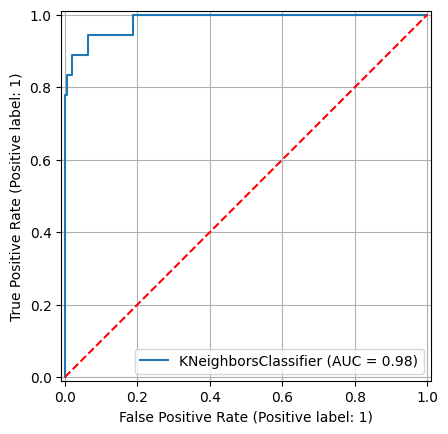

In [23]:
display_roc_graph(knn_tuned, X_test, y_test)

In [24]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       155
           1       0.84      0.89      0.86        18

    accuracy                           0.97       173
   macro avg       0.91      0.93      0.92       173
weighted avg       0.97      0.97      0.97       173



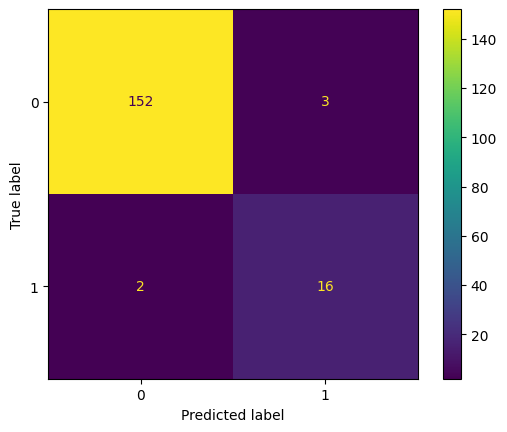

In [25]:
display_confusion_matrix(y_test, y_pred_knn)

# Logistic Regression Classifier

## Find the best hyperparameter for logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
param_grid_lr = {
    # from .001 to 1000
    "C": np.logspace(-3, 3, 7),
    "solver": ["newton-cg", "lbfgs", "liblinear"],
    "penalty": ["l2"]
}
lr_cv = GridSearchCV(lr, param_grid_lr, cv=7, verbose=1, scoring="roc_auc")
lr_cv.fit(X_train, y_train)
best_params_lr = lr_cv.best_params_
print("Tuned parameters:", best_params_lr)

Fitting 7 folds for each of 21 candidates, totalling 147 fits
Tuned parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}


## Test Tuned Logistic Regression Model

In [27]:
lr_tuned = LogisticRegression(**best_params_lr)
lr_tuned.fit(X_train, y_train)
lr_metrics, y_pred_lr = compute_model_metrics(lr_tuned, X_test, y_test)
CLASSIFIERS_SCORES["LogisticRegression"] = lr_metrics
print_metrics("Logisitic Regression Metrics", lr_metrics)

Logisitic Regression Metrics
-------------------------------
Accuracy = 0.942
Precision = 0.682
Recall = 0.833
F1-score = 0.750
ROC/AUC = 0.981


In [28]:
print(metrics.classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       155
           1       0.68      0.83      0.75        18

    accuracy                           0.94       173
   macro avg       0.83      0.89      0.86       173
weighted avg       0.95      0.94      0.94       173



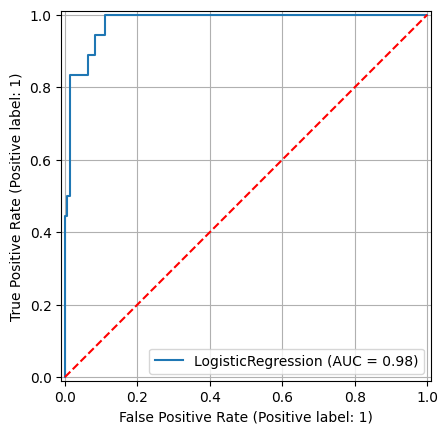

In [29]:
display_roc_graph(lr_tuned, X_test, y_test)

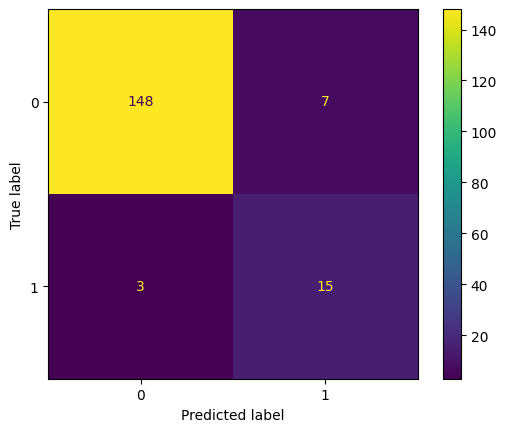

In [30]:
display_confusion_matrix(y_test, y_pred_lr)

In [31]:
print(metrics.classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       155
           1       0.68      0.83      0.75        18

    accuracy                           0.94       173
   macro avg       0.83      0.89      0.86       173
weighted avg       0.95      0.94      0.94       173



# Naive Bayes Classifier

## Find the best hyperparameter for Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
param_grid_gnb = {
    'var_smoothing': np.logspace(0, -11, 100)
}
gnb_cv = GridSearchCV(gnb, param_grid_gnb, cv=10, verbose=1, scoring="roc_auc")
gnb_cv.fit(X_train, y_train)
best_params_gnb = gnb_cv.best_params_
print("Gaussian Naive Bayes tuned parameters:", best_params_gnb)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Gaussian Naive Bayes tuned parameters: {'var_smoothing': 1.0}


## Test Tunded Gaussian Naive Bayes

In [33]:
gnb_tuned = GaussianNB(**best_params_gnb)
gnb_tuned.fit(X_train, y_train)
gnb_metrics, y_pred_gnb = compute_model_metrics(gnb_tuned, X_test, y_test)
CLASSIFIERS_SCORES["NaiveBayes"] = gnb_metrics
print_metrics("Naive Bayes Metrics", gnb_metrics)

Naive Bayes Metrics
-------------------------------
Accuracy = 0.902
Precision = 0.545
Recall = 0.333
F1-score = 0.414
ROC/AUC = 0.904


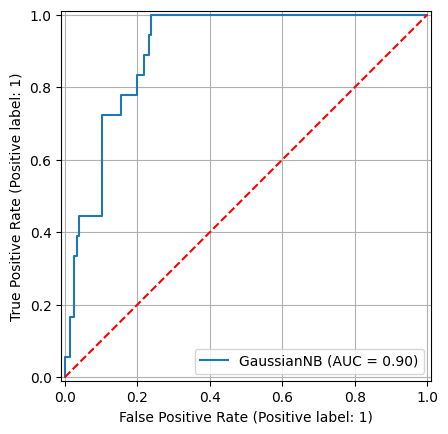

In [34]:
display_roc_graph(gnb_tuned, X_test, y_test)

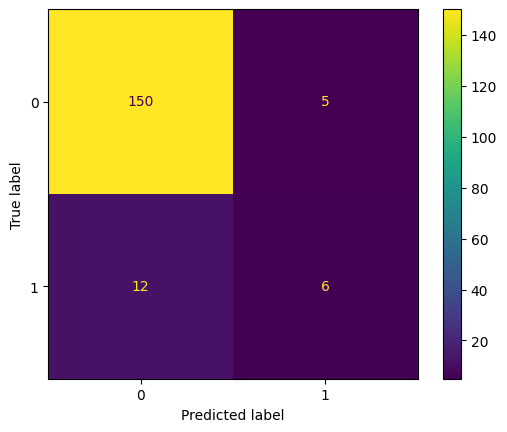

In [35]:
display_confusion_matrix(y_test, y_pred_gnb)

In [36]:
print(metrics.classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       155
           1       0.55      0.33      0.41        18

    accuracy                           0.90       173
   macro avg       0.74      0.65      0.68       173
weighted avg       0.89      0.90      0.89       173



### `Note`: Naive Bayes is sensitive to features and their correlations, so we can further tune it by including PCA to a pipeline

In [37]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps= [("PCA", PCA(random_state=random_state)), ("GaussianNB", GaussianNB())])
param_grid_pca_gnb = {
    'PCA__n_components': range(1, X_train.shape[1]+1),
    'GaussianNB__var_smoothing': np.logspace(0, -9, 100)
}
pca_gnb_cv = GridSearchCV(pipeline, param_grid_pca_gnb, cv=10, verbose=1, scoring="roc_auc")
pca_gnb_cv.fit(X_train_, y_train)
best_params_pca_gnb = pca_gnb_cv.best_params_
print("Gaussian Naive Bayes tuned parameters:", best_params_pca_gnb)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Gaussian Naive Bayes tuned parameters: {'GaussianNB__var_smoothing': 0.01873817422860384, 'PCA__n_components': 7}


# Test tuned gaussian Naive Bayes with PCA 

In [38]:
pca = PCA(best_params_pca_gnb["PCA__n_components"], random_state=random_state)
X_train_reduced = pca.fit_transform(X_train_)
X_test_reduced = pca.transform(X_test_)

pca_gnb_tuned = GaussianNB(var_smoothing=best_params_pca_gnb["GaussianNB__var_smoothing"])
pca_gnb_tuned.fit(X_train_reduced, y_train)
pca_gnb_metrics, y_pred_pca_gnb = compute_model_metrics(pca_gnb_tuned, X_test_reduced, y_test)
CLASSIFIERS_SCORES["NaiveBayesPCA"] = pca_gnb_metrics
print_metrics("PCA with Naive Bayes Metrics", pca_gnb_metrics)

PCA with Naive Bayes Metrics
-------------------------------
Accuracy = 0.931
Precision = 0.800
Recall = 0.444
F1-score = 0.571
ROC/AUC = 0.965


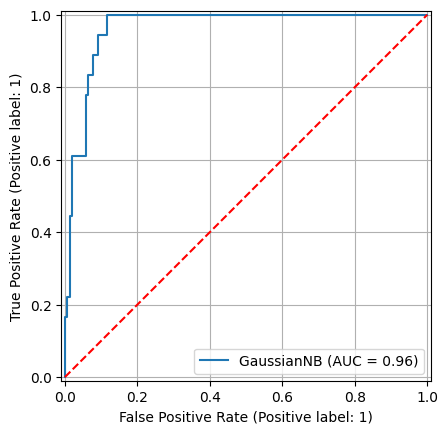

In [39]:
display_roc_graph(pca_gnb_tuned, X_test_reduced, y_test)

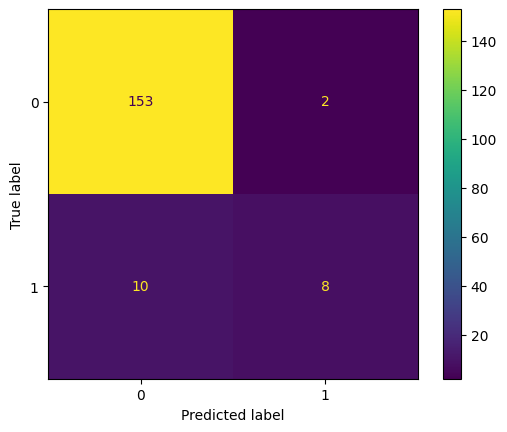

In [40]:
display_confusion_matrix(y_test, y_pred_pca_gnb)

In [41]:
print(metrics.classification_report(y_test, y_pred_pca_gnb))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       155
           1       0.80      0.44      0.57        18

    accuracy                           0.93       173
   macro avg       0.87      0.72      0.77       173
weighted avg       0.92      0.93      0.92       173



# SVM Classifier

## Find the best hyperparameters for SVM

In [42]:
from sklearn.svm import SVC
svm = SVC(random_state=random_state)
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "degree": [2, 3, 4],
    "gamma": [0.1, 1, "scale", "auto"]
}
svm_cv = GridSearchCV(svm, param_grid_svm, cv=10, verbose=1, scoring="roc_auc")
svm_cv.fit(X_train, y_train)
best_params_svm = svm_cv.best_params_
print("SVM tuned parameters:", best_params_svm)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
SVM tuned parameters: {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


## Test tuned SVM

In [43]:
svm_tuned = SVC(probability=True, random_state=random_state, **best_params_svm)
svm_tuned.fit(X_train, y_train)
svm_metrics, y_pred_svm = compute_model_metrics(svm_tuned, X_test, y_test)
CLASSIFIERS_SCORES["SVM"] = svm_metrics
print_metrics("SVM Metrics", svm_metrics)

SVM Metrics
-------------------------------
Accuracy = 0.942
Precision = 0.667
Recall = 0.889
F1-score = 0.762
ROC/AUC = 0.980


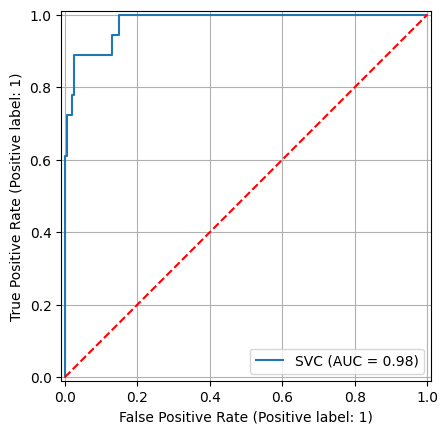

In [44]:
display_roc_graph(svm_tuned, X_test, y_test)

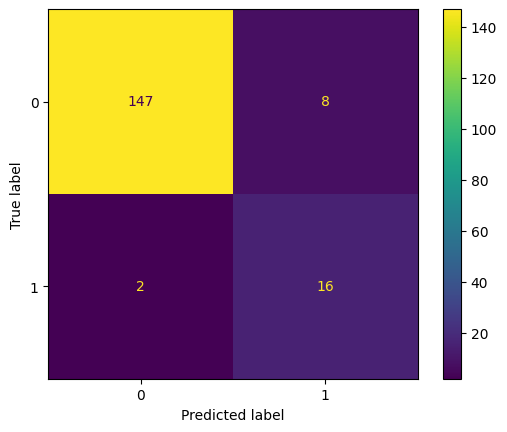

In [45]:
display_confusion_matrix(y_test, y_pred_svm)

In [46]:
print(metrics.classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       155
           1       0.67      0.89      0.76        18

    accuracy                           0.94       173
   macro avg       0.83      0.92      0.86       173
weighted avg       0.95      0.94      0.95       173



# Decision Tree Classifier

## Find the best hyperparameters for Decision tree classifier

In [47]:
# TOOD: tunning

## Test the tuned decision tree classifier

In [48]:
# TODO: testing

# Summary

In [49]:
pd.DataFrame(CLASSIFIERS_SCORES)

,KNN,LogisticRegression,NaiveBayes,NaiveBayesPCA,SVM
Accuracy,0.971098,0.942197,0.901734,0.930636,0.942197
Precision,0.842105,0.681818,0.545455,0.800000,0.666667
Recall,0.888889,0.833333,0.333333,0.444444,0.888889
F1-score,0.864865,0.750000,0.413793,0.571429,0.761905
ROC/AUC,0.984588,0.981004,0.903584,0.964516,0.979928


In [50]:
## TODO: add the summary of  metrics for svm and decision trees in more organized way

**Based on the metrics above, the KNN classifier demonstrates superior performance across all evaluation measures compared to Logistic Regression and Naive Bayes. KNN shows the best discriminative ability with a ROC/AUC score of 0.985. While Logistic Regression performs reasonably well with an accuracy of 94.2% and good ROC/AUC score of 0.981, its precision and recall metrics are notably lower than KNN. Naive Bayes significantly underperforms compared to both alternatives, particularly struggling with recall (33.3%) and precision (54.5%), making KNN the clear choice for this classification task. However, using a PCA before Naive Bayes greatly enhances| the classification metrics.**

### Histogram of classification metrics

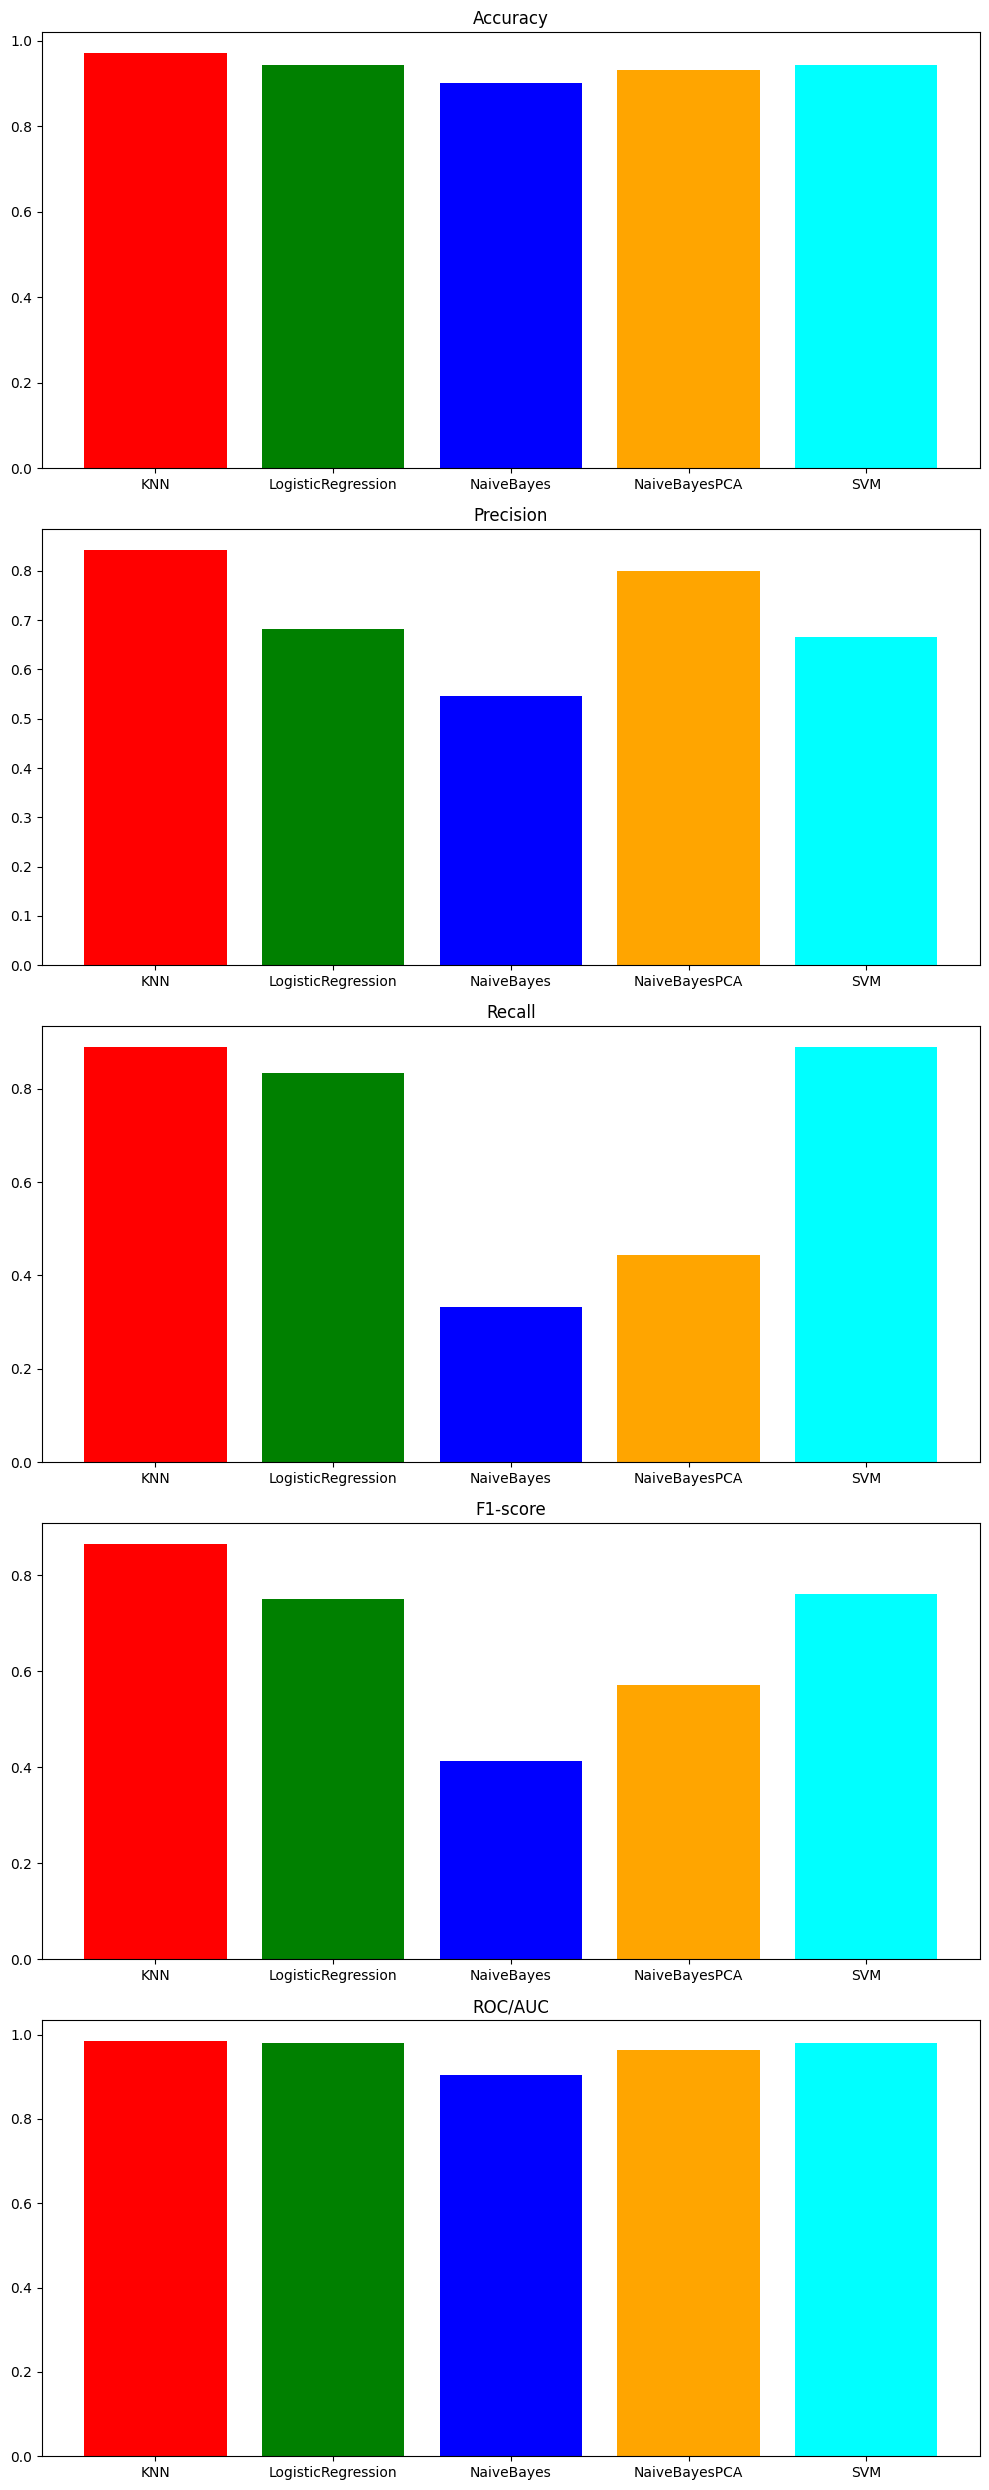

In [51]:
plot_metrics_histograms(CLASSIFIERS_SCORES)